# 제 1 유형

> 데이터셋
* https://www.kaggle.com/shubh0799/churn_modelling
* 고객의 신상정보 데이터를 통한 회사 서비스 이탈 예측(종속변수: Exited)

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churn/train.csv")

## Q1.
> 남성 이탈(Exited)이 가장 많은 국가(Geography)는 어디이고 이탈 인원은 몇명인가?

In [19]:
exit_cnt_df = df.groupby(["Gender", "Geography"], as_index=False).agg({"Exited": pd.Series.sum})
male_exit_cnt = exit_cnt_df[exit_cnt_df.Gender == "Male"]
print(male_exit_cnt.sort_values("Exited", ascending=False).iloc[0][["Geography", "Exited"]])

Geography    Germany
Exited           287
Name: 4, dtype: object


## Q2.
> 카드를 소유(HasCrCard == 1)하고 있으면서 활성멤버(IsAcitiveMember == 1) 인 고객들의 평균나이는?

In [32]:
print(df[(df.HasCrCard == 1) & (df.IsActiveMember == 1)].Age.mean())

39.61019283746556


## Q3.
> Balance 값이 중간값 이상을 가지는 고객들의 CreditScore의 표준편차를 구하여라.

In [37]:
bal_median = df.Balance.median()
df[df.Balance > bal_median].CreditScore.std()

97.30664968532072

# 제 2 유형

> 데이터
* https://archive.ics.uci.edu/ml/datasets/Breast%20Cancer%20Wisconsin%20(Diagnotic)
* 유방암 발생여부 예측(종속변수: diagnosis(B: 양성, M: 악성)
* 평가지표: f1_score

In [40]:
import pandas as pd

train_df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/cancer/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/cancer/test.csv")
submission_df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/cancer/submission.csv")

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 454 non-null    int64  
 1   diagnosis          454 non-null    object 
 2   radius_mean        454 non-null    float64
 3   texture_mean       454 non-null    float64
 4   perimeter_mean     454 non-null    float64
 5   area_mean          454 non-null    float64
 6   smoothness_mean    454 non-null    float64
 7   compactness_mean   454 non-null    float64
 8   concavity_mean     454 non-null    float64
 9   points_mean        454 non-null    float64
 10  symmetry_mean      454 non-null    float64
 11  dimension_mean     454 non-null    float64
 12  radius_se          454 non-null    float64
 13  texture_se         454 non-null    float64
 14  perimeter_se       454 non-null    float64
 15  area_se            454 non-null    float64
 16  smoothness_se      454 non

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure

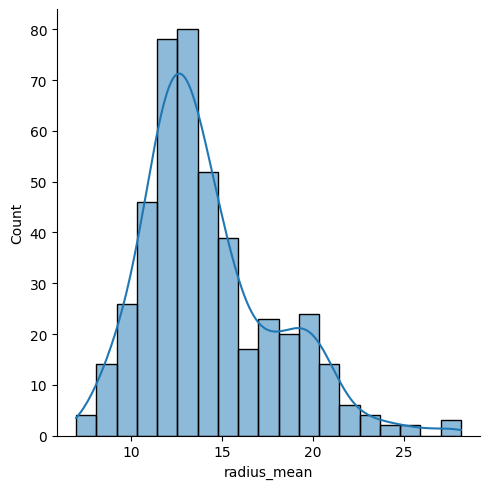

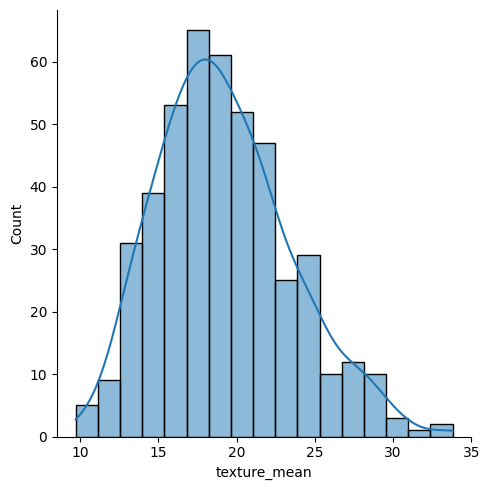

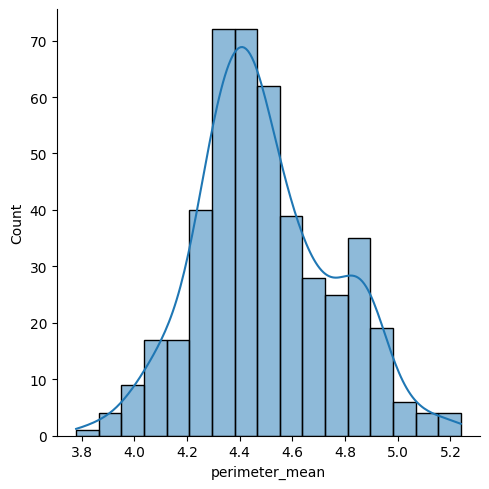

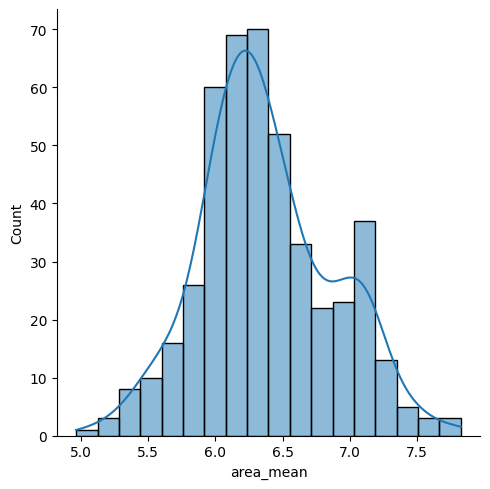

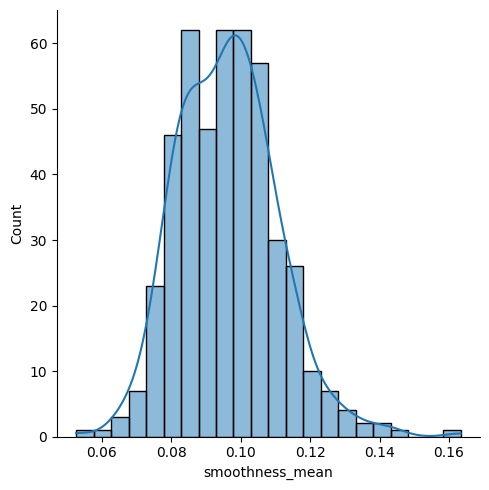

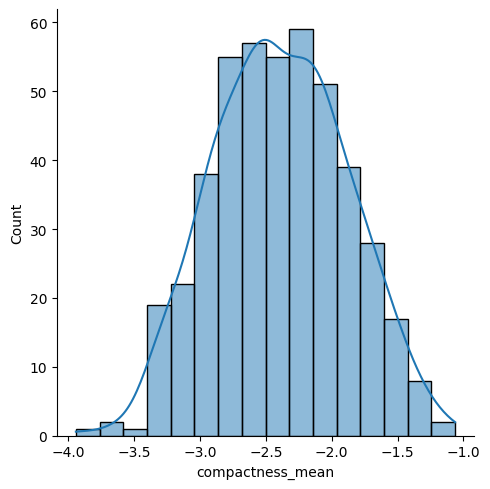

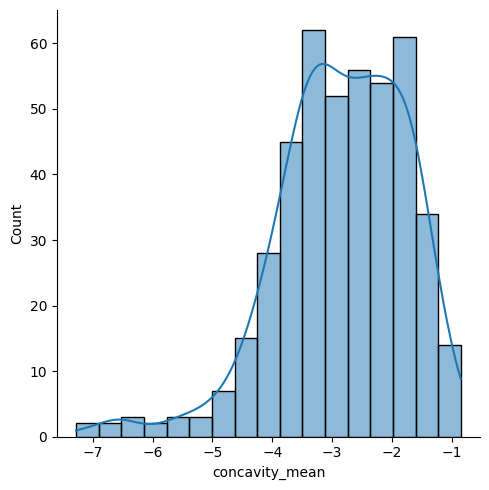

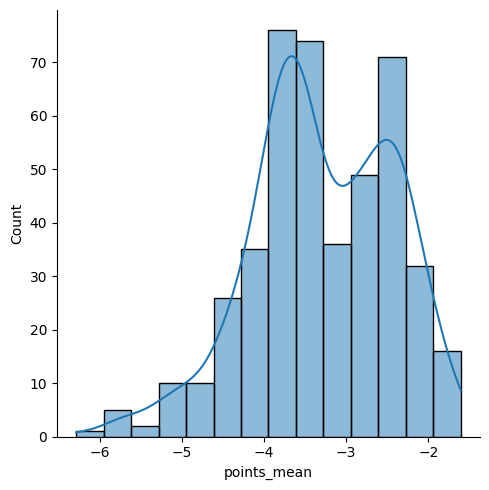

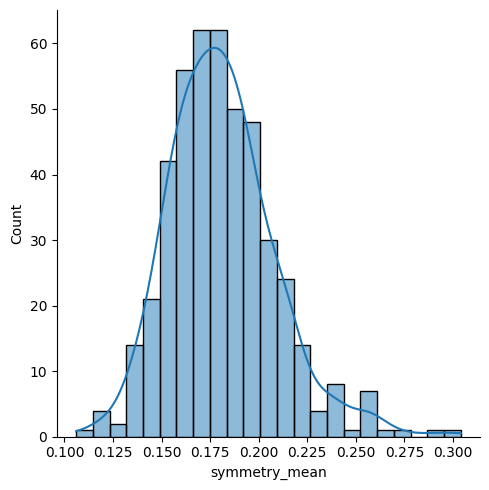

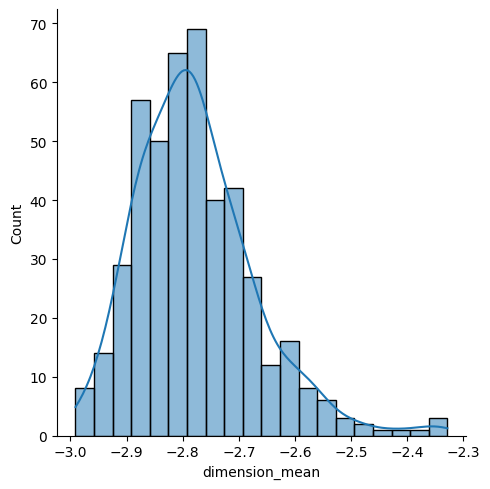

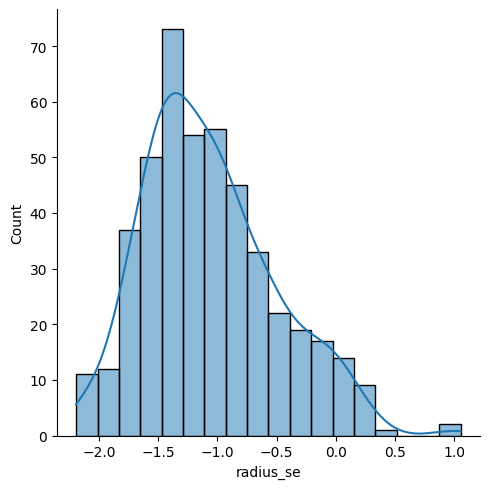

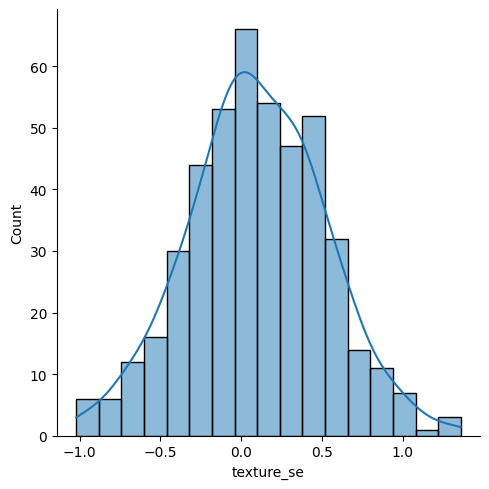

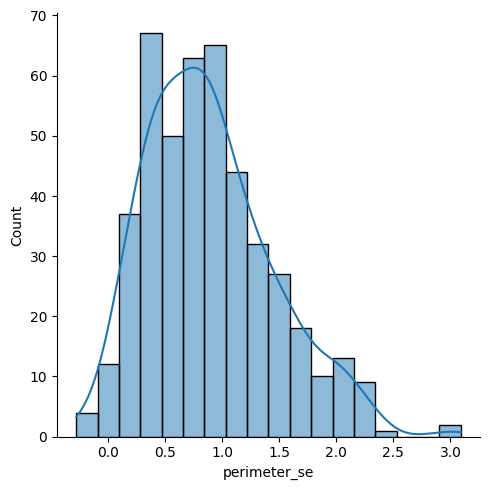

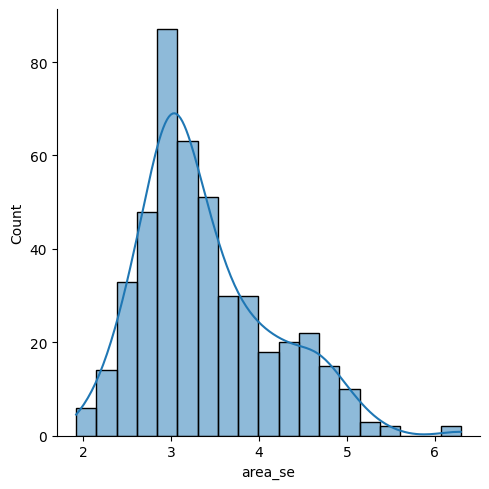

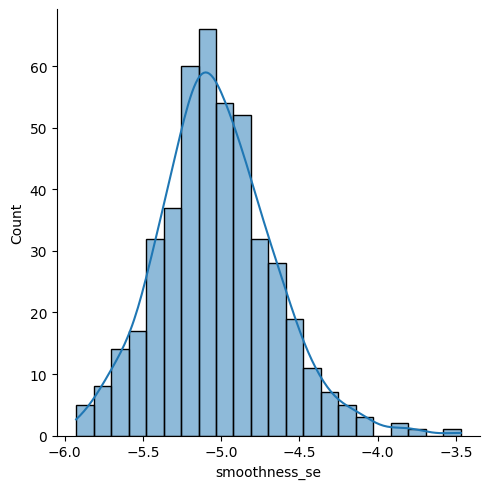

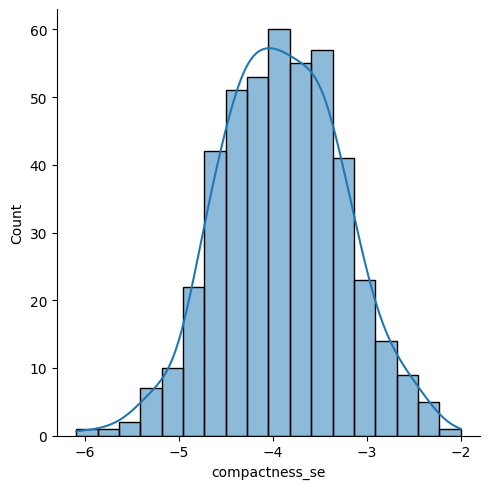

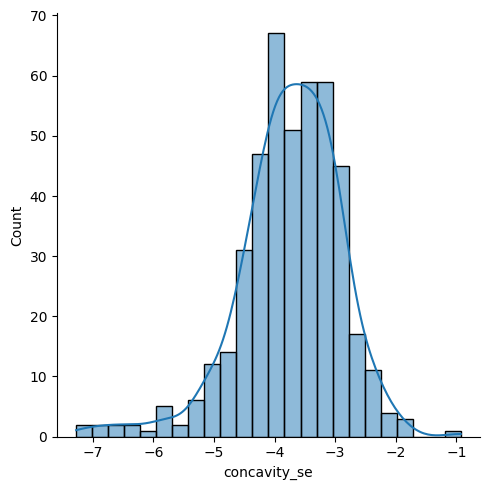

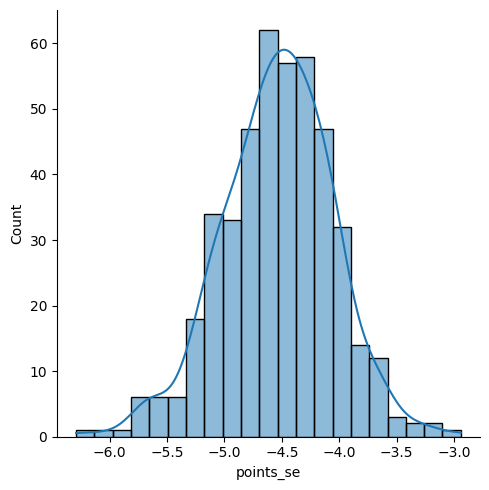

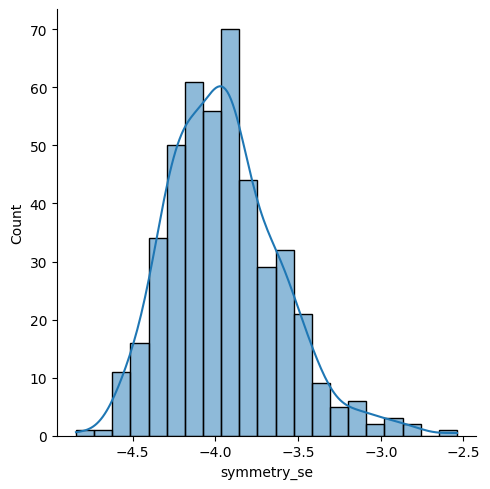

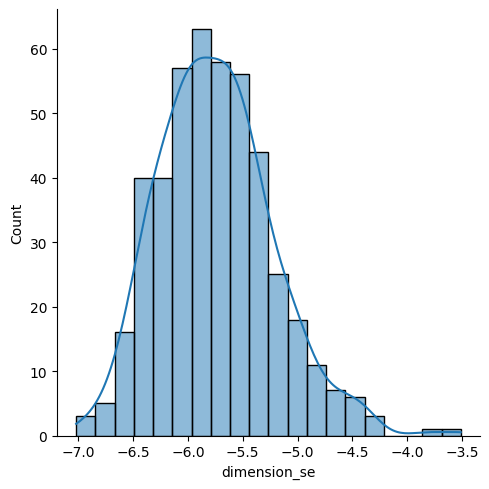

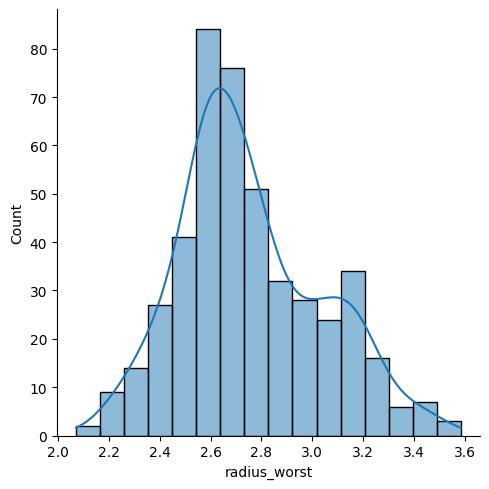

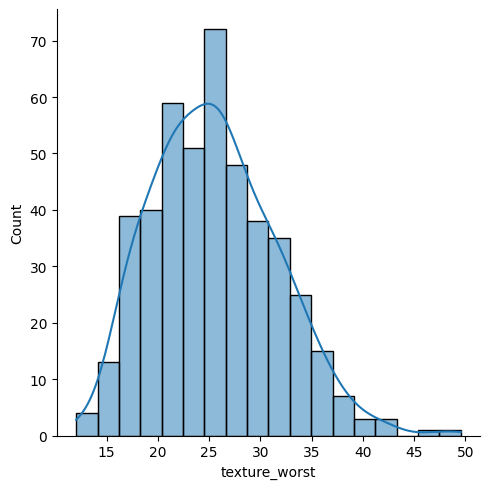

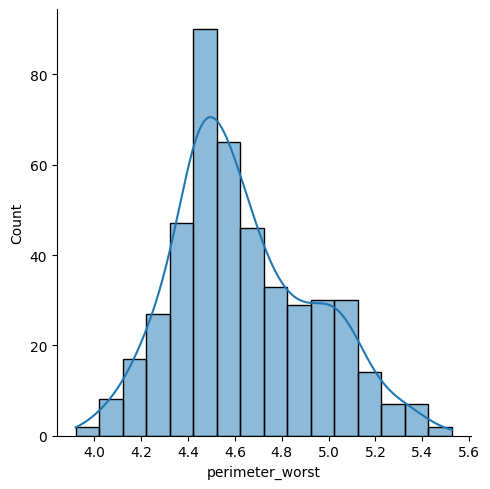

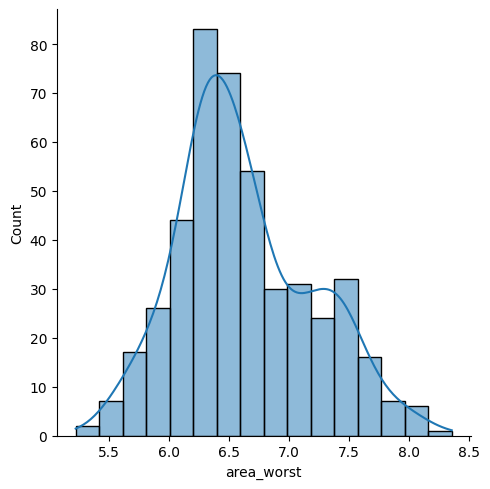

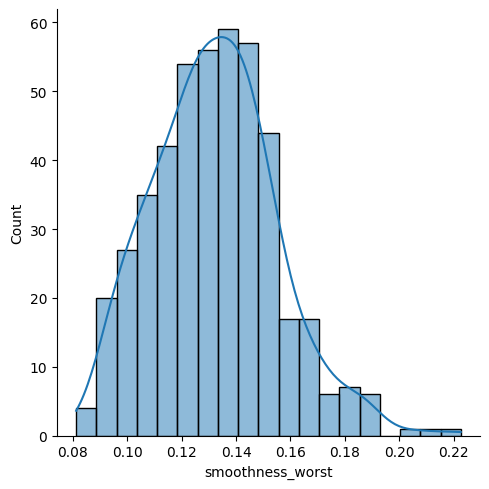

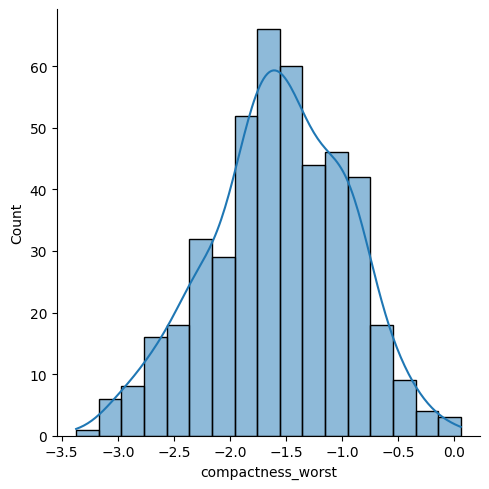

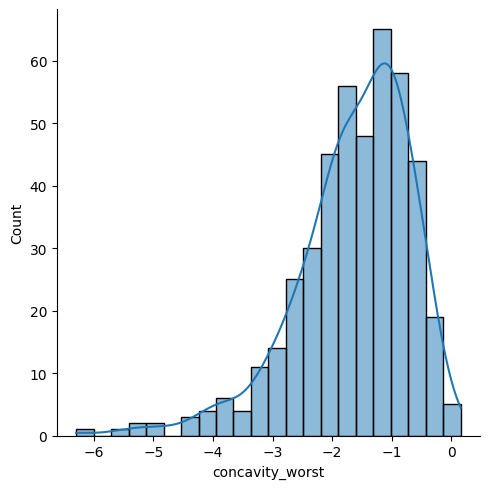

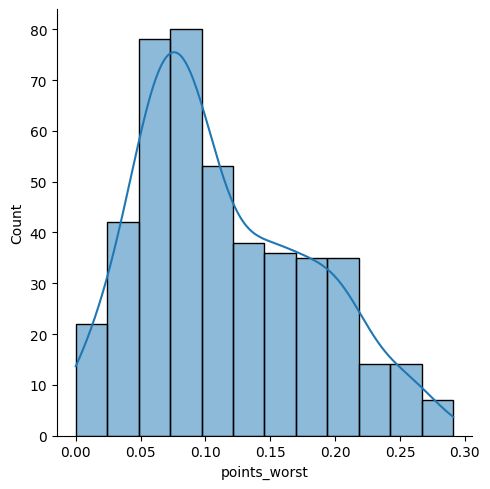

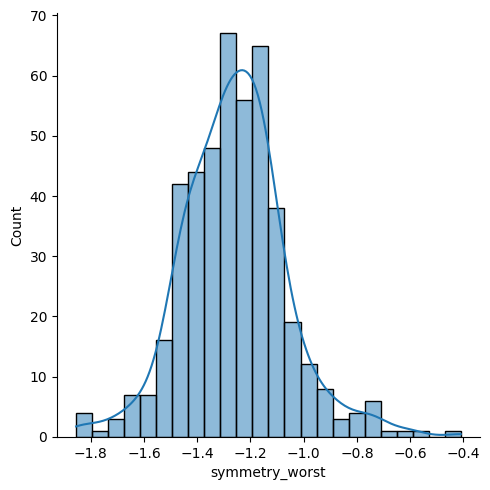

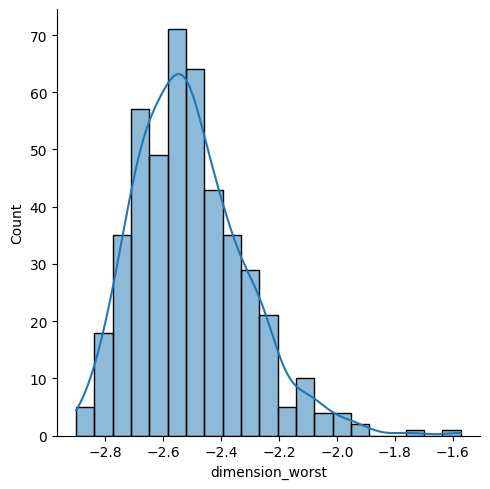

In [55]:
import numpy as np
import seaborn as sns
import scipy.stats as stats

for col in train_df.columns[2:]:
    if stats.skew(train_df[col]) > 1:
        sns.displot(np.log(train_df[col]), kde=True)
    else:
        sns.displot(train_df[col], kde=True)

## 함수, z-정규화 진행

In [100]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

def my_preprocessing(org_df, target="train", scaler=None):
    df = org_df.copy()
    df.drop("id", axis=1, inplace=True)

    if target == "train":
        scaler1 = StandardScaler()
        df = scaler1.fit_transform(df)
        df = pd.DataFrame(df, columns=org_df.columns[1:])     

        return df, scaler1

    elif target == "test":
        scaler1 = scaler
        df = scaler1.transform(df)
        df = pd.DataFrame(df, columns=org_df.columns[1:])

        return df

## 훈련, 검증 데이터 분할

In [101]:
from sklearn.model_selection import train_test_split

X = train_df.drop("diagnosis", axis=1)
y = train_df["diagnosis"]
y = y.replace({"B": 0, "M": 1})

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

## 전처리 함수 실행

In [102]:
X_train_processed, scaler = my_preprocessing(X_train, target="train")
X_valid_processed = my_preprocessing(X_valid, target="test", scaler=scaler)
test_processed = my_preprocessing(test_df, target="test", scaler=scaler)

## 분석

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, classification_report

### 로지스틱 회귀

In [105]:
model_logit = LogisticRegression(penalty="l2", max_iter=200)
model_logit.fit(X_train_processed, y_train)
pred = model_logit.predict(X_valid_processed)

logit_rpt = classification_report(y_valid, pred)
print(logit_rpt)

logit_f1 = f1_score(y_valid, pred)
print(logit_f1)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        57
           1       1.00      0.91      0.95        34

    accuracy                           0.97        91
   macro avg       0.97      0.96      0.96        91
weighted avg       0.97      0.97      0.97        91

0.9538461538461539


### 랜덤 포레스트

In [120]:
scores = []
for depth in range(3, 11):
    model_rf = RandomForestClassifier(max_depth=depth, class_weight={0:0.63, 1:0.37}, random_state=11)
    model_rf.fit(X_train_processed, y_train)
    pred = model_rf.predict(X_valid_processed)
    scores.append(f1_score(y_valid, pred))

pd.DataFrame(scores, index=range(3,11), columns=["f1"]).sort_values("f1", ascending=False)

,f1
6,0.953846
7,0.953846
8,0.953846
9,0.953846
10,0.953846
4,0.937500
5,0.937500
3,0.920635


* max_depth가 6일 때 가장 높음

In [121]:
model_rf = RandomForestClassifier(max_depth=6, class_weight={0:0.63, 1:0.37}, random_state=11)
model_rf.fit(X_train_processed, y_train)
pred = model_rf.predict(X_valid_processed)

rf_rpt = classification_report(y_valid, pred)
rf_f1 = f1_score(y_valid, pred)

print(rf_rpt)
print(rf_f1)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        57
           1       1.00      0.91      0.95        34

    accuracy                           0.97        91
   macro avg       0.97      0.96      0.96        91
weighted avg       0.97      0.97      0.97        91

0.9538461538461539


### Gradient Boosting

In [122]:
scores = []

for depth in range(3, 11):
    model_gb = GradientBoostingClassifier(max_depth=depth, random_state=11)
    model_gb.fit(X_train_processed, y_train)
    pred = model_gb.predict(X_valid_processed)
    scores.append(f1_score(y_valid, pred))

pd.DataFrame(scores, index=range(3, 11), columns=["f1"]).sort_values("f1", ascending=False)

,f1
3,0.898551
4,0.898551
6,0.882353
7,0.882353
8,0.882353
9,0.882353
10,0.882353
5,0.873239


### AdaBoost

In [124]:
model_ab = AdaBoostClassifier(random_state=11)
model_ab.fit(X_train_processed, y_train)
pred = model_ab.predict(X_valid_processed)

ab_rpt = classification_report(y_valid, pred)
ab_f1 = f1_score(y_valid, pred)

print(ab_rpt)
print(ab_f1)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        57
           1       0.94      0.97      0.96        34

    accuracy                           0.97        91
   macro avg       0.96      0.97      0.96        91
weighted avg       0.97      0.97      0.97        91

0.9565217391304348


### KNN

In [127]:
scores = []

for k in range(1, 11):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train_processed, y_train)
    pred = model_knn.predict(X_valid_processed)
    scores.append(f1_score(y_valid, pred))

pd.DataFrame(scores, index=range(1,11), columns=["f1"]).sort_values("f1", ascending=False)

,f1
3,0.925373
9,0.903226
1,0.901408
7,0.892308
6,0.888889
5,0.878788
2,0.875000
4,0.875000
8,0.866667
10,0.866667


In [128]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train_processed, y_train)
pred = model_knn.predict(X_valid_processed)

knn_rpt = classification_report(y_valid, pred)
knn_f1 = f1_score(y_valid, pred)
print(knn_rpt)
print(knn_f1)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96        57
           1       0.94      0.91      0.93        34

    accuracy                           0.95        91
   macro avg       0.94      0.94      0.94        91
weighted avg       0.94      0.95      0.94        91

0.9253731343283583


### SVM

In [141]:
model_svm = SVC(kernel="linear", C=1, random_state=11)
model_svm.fit(X_train_processed, y_train)
pred = model_svm.predict(X_valid_processed)

svm_rpt = classification_report(y_valid, pred)
svm_f1 = f1_score(y_valid, pred)

print(svm_rpt)
print(svm_f1)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        57
           1       1.00      0.94      0.97        34

    accuracy                           0.98        91
   macro avg       0.98      0.97      0.98        91
weighted avg       0.98      0.98      0.98        91

0.9696969696969697


In [144]:
print(f"로지스틱: {logit_f1:.4f}")
print(f"랜덤포레스트: {rf_f1:.4f}")
print(f"AdaBoost: {ab_f1:.4f}")
print(f"KNN: {knn_f1:.4f}")
print(f"SVM: {svm_f1:.4f}")

로지스틱: 0.9538
랜덤포레스트: 0.9538
AdaBoost: 0.9565
KNN: 0.9254
SVM: 0.9697


* 서포트 벡터 머신이 가장 잘 예측함

In [145]:
test_pred = model_svm.predict(test_processed)
submission_df["0"] = test_pred

In [149]:
submission_df.to_csv("submission_pred.csv")